# TF activity inference from scRNA-seq data with DoRothEA as regulon resource

## Introduction

DoRothEA is a comprehensive resource containing a curated collection of transcription factors (TFs) and its transcriptional targets. The set of genes regulated by a specific transcription factor is known as regulon. DoRothEA’s regulons were gathered from different types of evidence. Each TF-target interaction is defined by a confidence level based on the number of supporting evidence. The confidence levels ranges from A (highest confidence) to E (lowest confidence) (Garcia-Alonso et al. 2019). DoRothEA regulons are usually coupled with a footprint-based enrichment method to compute TF activities based on the levels of expression of their target genes (Dugourd and Saez-Rodriguez 2019). For an introduction to Footprint-based enrichment analysis please visit this other [notebook](https://github.com/saezlab/dorothea-py/blob/main/example/dorothea_introduction.ipynb) and if you are interested in how different algorithms perform consider checking [DecoupleR](https://github.com/saezlab/decoupleR). 

Holland et al. (2020) evaluated the performance of DoRothEA when applied to scRNA-seq data. We showed that, in spite of the current limitations of scRNA-seq technologies, their approach can provide meaningful results in this context. Indeed, this vignette shows an example on how to apply DoRothEA regulons coupled with the statistic normalized mean in a well known single-cell dataset.

Here we load the packages required to run this notebook.

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
from anndata import AnnData
import dorothea
import matplotlib.pyplot as plt

## Single-cell RNA-seq dataset

### Data description

In the following paragraphs, we provide examples describing how to run normalized mean on DoRothEA regulons in a scRNA-seq dataset using the Scanpy toolkit for single cell genomics (Wolf et al. 2018). For the sake of simplicity, we follow the example provided in the following Scanpy vignette:

https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

The dataset contains 2700 Peripheral Blood Mononuclear Cells (PBMC) that were sequenced on the Illumina NextSeq 500. This dataset is freely available in 10X Genomics:

https://cf.10xgenomics.com/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz

On a unix system, you can uncomment and run the following to download and unpack the data:

In [2]:
#!mkdir data
#!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
#!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

In [3]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',
    var_names='gene_symbols',                
    cache=True)                              
adata.var_names_make_unique()

### Pre-processing, normalization and identification of highly variable features

We follow the standard pre-processing steps as described in the aforementioned Scanpy vignette before going deeper into the data analysis. These steps carry out the selection and filtration of cells based on quality control metrics, the data normalization and scaling, and the detection of highly variable features.

In [4]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Filter cells following standard QC criteria.
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

# Store raw counts
adata.layers["counts"] = adata.X

# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Identify the 2000 most highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Filter higly variable genes
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

# Regress and scale the data
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

### Clustering cells

One of the most relevant steps in scRNA-seq data analysis is clustering. Cells are grouped based on the similarity of their transcription profiles. We first apply the Scanpy approach as described in their aforementioned tutorial. We visualize the cell clusters using UMAP:

In [5]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata)

new_cluster_names = [
    'CD4 T',
    'CD14 Monocytes',
    'B',
    'CD8 T',
    'NK',
    'FCGR3A Monocytes',
    'Dendritic',
    'Megakaryocytes'
]


adata.rename_categories('leiden', new_cluster_names)
adata.obs["cell_type"] = adata.obs['leiden']

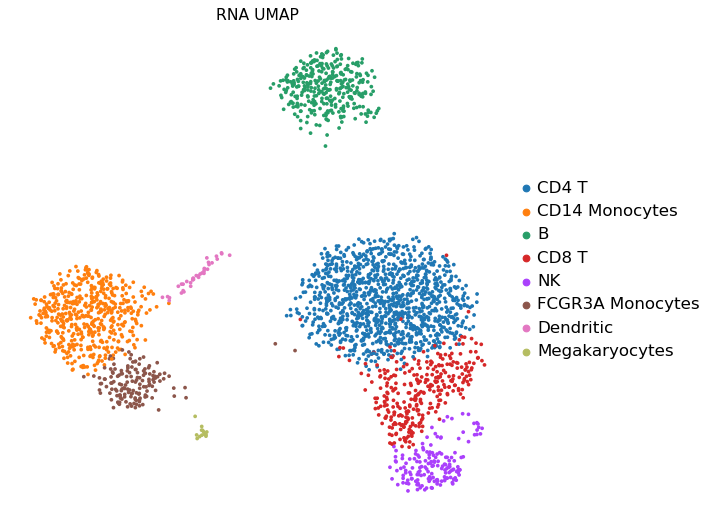

In [6]:
sc.set_figure_params(figsize=(8,8))
sc.pl.umap(adata, color='cell_type', title='RNA UMAP', 
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

## TF activity prediction

### Method

As previously mentioned, DoRothEA’s regulons can be coupled to any foot-print based enrichment analysis statistic to estimate TF activities from expression data. Specifically, in this package we implemented the normalized mean controlled by permutations. Given a TF regulon with $n$ number of target genes $g = (g_1, ... g_n)$ and weights $w = (w_1, ... w_n)$, its estimated activity is defined as:

$ E = \frac{\sum_{i=1}^{n}{g_i w_i}}{n} $

Activities are normalized by $n$ to control for large regulons. Moreover, to control for false estimations we calculate the probability of observing the estimated activity by chance, by performing $m$ permutations:

$pval = \frac{\sum_{i=1}^{m}{\left\lvert R_i \right\rvert > \left\lvert E \right\rvert}}{m}$

Where $R_i$ is the predicted activity using $n$ random target genes. Finally, the final TF activity $A$ is calculated by weighting $E$ by its $pval$:

$A = E * -\log_{10}(pval)$

Therefore, cells will show high absolute values of TF activity if their estimate is robust, otherwise their predicted activity will be close to 0. 

### Prediction

To predict TF activities, first we need to load the DoRothEA network (only available for Human and Mouse):

In [7]:
regulons = dorothea.load_regulons(
    ['A','B','C'], # Which levels of confidence to use (A most confident, E least confident)
    organism='Human' # If working with mouse, set to Mouse
)

To run normalized mean use:

In [8]:
dorothea.run(adata,
             regulons,
             center=True,  # Center gene expression by mean per cell
             num_perm=100, # Simulate m random activities
             norm=True,    # Normalize by number of edges to correct for large regulons
             scale=True,   # Scale values per feature so that values can be compared across cells
             use_raw=True, # Use lognorm gene expression
             min_size=5,   # TF with less than 5 targets will be ignored
            ) 

  0%|          | 0/100 [00:00<?, ?it/s]

3991 targets found
8 TFs with < 5 targets


100%|██████████| 100/100 [00:10<00:00,  9.59it/s]


The resulting activities are stored in the `.obsm` attribute of an `AnnData` object. To access them use the key `dorothea`:

In [9]:
adata.obsm['dorothea']

tf,AHR,AR,ARID1A,ARID1B,ARID2,ARID3A,ARNT,ARNTL,ASCL1,ATF1,...,ZKSCAN1,ZNF143,ZNF217,ZNF24,ZNF263,ZNF274,ZNF384,ZNF592,ZNF639,ZNF740
AAACATACAACCAC-1,0.637719,0.128482,0.494505,0.527132,-1.110640,2.778244,-0.496031,-0.403108,-1.639834,-0.331001,...,-0.234314,0.011739,-0.438638,0.397951,1.510536,0.518675,-0.314592,-0.284191,-0.935563,-0.072476
AAACATTGAGCTAC-1,-0.694901,-0.705417,-0.040204,0.023827,-1.830315,-0.692222,-0.106184,-0.564728,0.507541,-0.236353,...,-0.858750,-0.285456,0.637781,0.744331,0.381436,-0.249708,0.102820,-0.482011,0.229305,0.252405
AAACATTGATCAGC-1,0.613023,1.733087,-1.373070,0.245103,-0.622450,0.266110,0.680542,-0.616725,-0.657840,-0.255873,...,-0.057293,0.103874,-0.774238,-0.485613,0.868059,-0.569201,0.463774,0.643859,-0.679534,3.798384
AAACCGTGCTTCCG-1,0.323603,-0.031242,-1.053801,0.315228,-0.351145,-1.296723,0.185890,-0.293995,0.391007,-0.349887,...,-0.596005,0.145258,0.373338,0.883082,-1.122907,0.564985,-2.283779,-0.503941,0.395780,-0.314479
AAACCGTGTATGCG-1,3.290613,-0.571413,2.270873,-0.293100,0.248068,0.505955,-0.431840,0.202106,0.457611,-0.550800,...,2.749933,0.153761,1.592558,0.415436,-1.157229,-1.041080,0.598091,0.959788,-0.989048,0.233625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,-0.282724,2.373813,0.052894,0.190399,-0.654010,0.316877,-0.293295,-0.194086,-0.543797,-0.369622,...,-0.722675,0.025478,0.336084,-0.447191,-1.141446,1.317667,0.550770,0.577671,0.413682,-0.149283
TTTCTACTGAGGCA-1,-0.305274,2.292671,-0.151249,-1.391867,0.268087,-0.074941,0.047387,-0.790424,0.460097,0.668282,...,-0.810852,0.108953,0.701377,-0.431918,1.721104,-0.811073,-0.701535,0.872679,-0.333182,-0.177046
TTTCTACTTCCTCG-1,-0.307621,-0.403623,-0.608054,1.014499,0.005069,-0.939137,0.192234,0.198266,0.509543,-0.308563,...,0.688629,-0.277931,-0.484854,0.394280,-1.061201,-0.929481,1.047279,-0.462209,0.934004,0.222969
TTTGCATGAGAGGC-1,-0.190628,-1.273328,0.772707,0.780478,-0.960230,-0.145595,-1.535694,0.277849,-0.579113,-0.610730,...,-0.398412,0.093336,-0.098109,0.026561,0.090279,-0.019089,0.002761,0.149773,-1.149088,-0.199032


Or use `extract` to return an AnnData object to be able to use scanpy's amazing plotting functions:

In [10]:
dorothea.extract(adata)

AnnData object with n_obs × n_vars = 2638 × 292
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type'
    obsm: 'X_pca', 'X_umap', 'dorothea'

## Foot-print based methods robustness

Downstream transcriptional targets of a TF yield a much more robust estimation of the TF activity than just observing the expression of the TF itself. To test this, we will compare the levels of expression of STAT5B with its predicted activity. STAT5B is a TF essential for natural killer (NK) cell-mediated proliferation and cytolytic activity. Therefore, we would expect that NK cells should have a higher value of activation than other cell types.

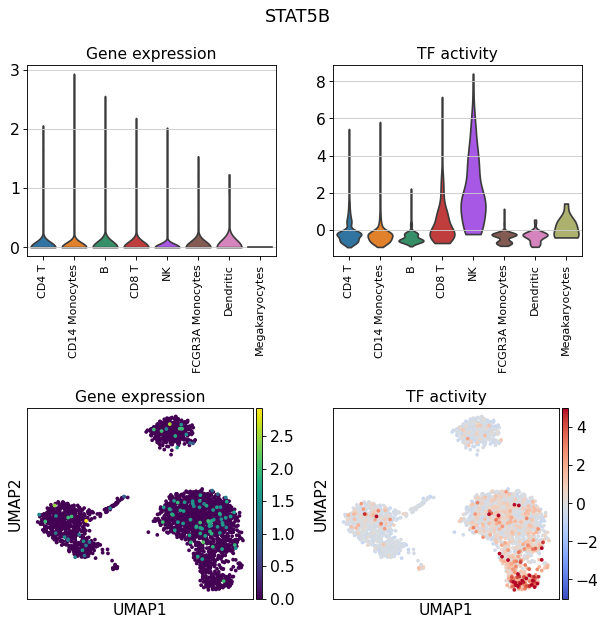

In [11]:
fig, ax = plt.subplots(2,2, figsize=(8,8), tight_layout=True, facecolor='white')
ax = ax.flatten()

tf = 'STAT5B'
fig.suptitle(tf, fontsize=16)
sc.pl.violin(adata, keys=tf, groupby='cell_type', stripplot=False, ax=ax[0], show=False)
ax[0].tick_params(axis='x', rotation=90, labelsize=10)
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].set_title('Gene expression')

sc.pl.violin(dorothea.extract(adata), keys=tf, groupby='cell_type', stripplot=False, ax=ax[1], show=False)
ax[1].tick_params(axis='x', rotation=90, labelsize=10)
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_title('TF activity')

sc.pl.umap(adata, color=tf, return_fig=False, ax=ax[2], show=False)
ax[2].set_title('Gene expression')
sc.pl.umap(dorothea.extract(adata), color=tf, vmin=-5, vmax=5, cmap='coolwarm', return_fig=False, ax=ax[3], show=False)
ax[3].set_title('TF activity')

plt.show()

As expected, NK cells show a high predicted TF activity for STAT5B. However, by looking at gene expression it would not be as obvious since very few cells show expression of the STAT5B gene. Another example is PAX5, a master regulator of B cells:

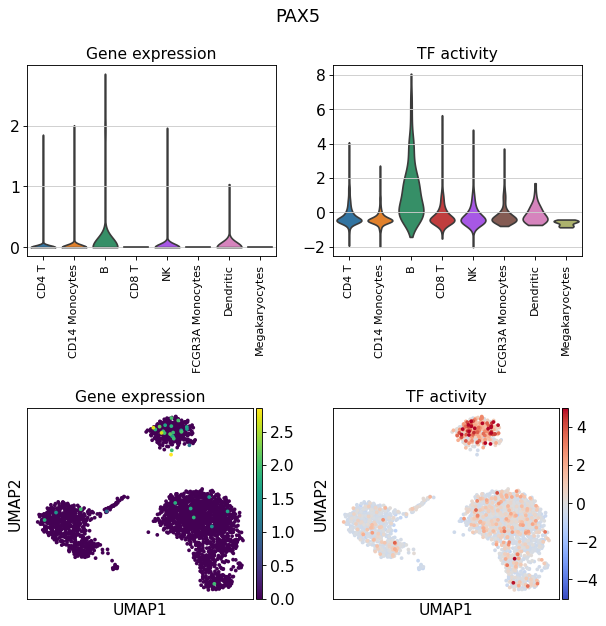

In [12]:
fig, ax = plt.subplots(2,2, figsize=(8,8), tight_layout=True, facecolor='white')
ax = ax.flatten()

tf = 'PAX5'
fig.suptitle(tf, fontsize=16)
sc.pl.violin(adata, keys=tf, groupby='cell_type', stripplot=False, ax=ax[0], show=False)
ax[0].tick_params(axis='x', rotation=90, labelsize=10)
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].set_title('Gene expression')

sc.pl.violin(dorothea.extract(adata), keys=tf, groupby='cell_type', stripplot=False, ax=ax[1], show=False)
ax[1].tick_params(axis='x', rotation=90, labelsize=10)
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_title('TF activity')

sc.pl.umap(adata, color=tf, return_fig=False, ax=ax[2], show=False)
ax[2].set_title('Gene expression')
sc.pl.umap(dorothea.extract(adata), color=tf, vmin=-5, vmax=5, cmap='coolwarm', return_fig=False, ax=ax[3], show=False)
ax[3].set_title('TF activity')

plt.show()

Based only in gene expression, very few B cells show expression of PAX5. On the contrary, DoRothEA’s regulons correctly predicts that many of the B cells show activity of this TF. Therefore, foot-print based methods allow for robust TF activity, even when no gene expression for that TF is available. This makes foot-print based methods very attractive for singe cell, since they can deal with drop-outs. 

## Comparison of TF activities between groups

Once TF activities are predicted, we can perform comparison tests to check if there are differences between groups. To do, we have implemented a wrapper for the Wilcoxon rank-sum test. Let's find what TFs show specific activity for NK cells:

In [13]:
df = dorothea.rank_tfs_groups(adata, groupby='cell_type', group='NK')
df.head(10)

,group,reference,statistic,pval,pval_adj
name,,,,,
STAT5B,NK,all,18.151000,1.260856e-73,3.681699e-71
STAT4,NK,all,17.323428,3.131368e-67,4.571798e-65
STAT5A,NK,all,17.136680,7.903656e-66,7.692892e-64
LYL1,NK,all,11.985564,4.229578e-33,2.470073e-31
ATF6,NK,all,11.269680,1.852428e-29,7.727271e-28
IRF1,NK,all,11.200034,4.075769e-29,1.487656e-27
IRF3,NK,all,10.156837,3.089361e-24,9.020934e-23
TBX21,NK,all,9.350074,8.758630e-21,1.826800e-19
SMAD1,NK,all,9.288391,1.566380e-20,2.858644e-19


As expected, STAT5B appears at the top of the TF with significant changes of activity from the rest of cells. Let's do the same for B cells:

In [14]:
df = dorothea.rank_tfs_groups(adata, groupby='cell_type', group='B')
df.head(10)

,group,reference,statistic,pval,pval_adj
name,,,,,
RFX5,B,all,28.177691,1.097576e-174,3.204922e-172
RFXAP,B,all,27.957037,5.413802e-172,5.269434e-170
RFXANK,B,all,27.957037,5.413802e-172,5.269434e-170
CREB1,B,all,22.538975,1.722594e-112,1.257493e-110
POU2F1,B,all,22.478097,6.799157e-112,3.970708e-110
NFYA,B,all,20.162145,2.105549e-90,1.024701e-88
PAX5,B,all,20.120086,4.922206e-90,2.053263e-88
POU2F2,B,all,15.991167,1.472467e-57,3.908729e-56
RBPJ,B,all,13.859220,1.118840e-43,2.333581e-42


Again, PAX5 appears at the top 10 list of TFs that change significantly from other cell types. Interestingly, RFX5, responsible for the production of MHC class II, is the top ranked TF in B cells. Let's check which TF define the T-cell lineage:

In [15]:
df = dorothea.rank_tfs_groups(adata, groupby='cell_type', group=['NK', 'CD4 T', 'CD8 T'], reference='all')
df.head(10)

,group,reference,statistic,pval,pval_adj
name,,,,,
TBX21,"NK, CD4 T, CD8 T",all,25.075534,9.196911e-139,2.983887e-137
ETS1,"NK, CD4 T, CD8 T",all,23.480564,6.444189e-122,1.710639e-120
MAF,"NK, CD4 T, CD8 T",all,20.047329,2.129777e-89,5.182457e-88
GATA3,"NK, CD4 T, CD8 T",all,18.542965,9.295269e-77,1.596599e-75
E2F4,"NK, CD4 T, CD8 T",all,18.041668,9.173312e-73,1.409793e-71
MYC,"NK, CD4 T, CD8 T",all,17.162136,5.100250e-66,7.446365e-65
TCF7L2,"NK, CD4 T, CD8 T",all,16.573248,1.087879e-61,1.443913e-60
SSRP1,"NK, CD4 T, CD8 T",all,16.361361,3.609687e-60,4.582734e-59
MYB,"NK, CD4 T, CD8 T",all,16.141557,1.302148e-58,1.584280e-57


TBX21 appears as the top ranked which is a TF that controls the development of T cells. Finally, let's plot the top activated TF per cell type:

/home/badi/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  __ = ax.pcolor(_color_df, **kwds)


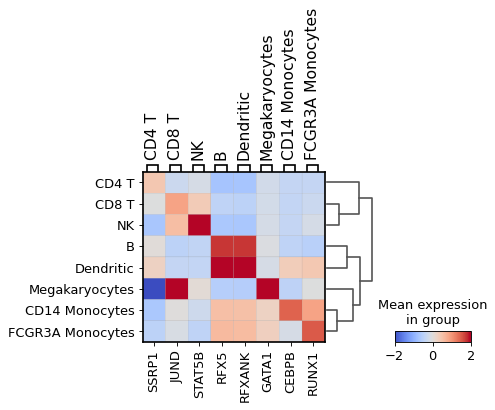

In [16]:
tfs = dict()
for cell_type in adata.obs.cell_type.cat.categories:
    df = dorothea.rank_tfs_groups(adata, groupby='cell_type', group=cell_type)
    tf = df.head(1).index.values
    tfs[cell_type] = tf
    
sc.pl.matrixplot(dorothea.extract(adata), tfs, 'cell_type', dendrogram=True, cmap='coolwarm', vmin=-2, vmax=2)

## Clustering cells with TF activity

Holland et al. (2020) showed that clustering the cells based on their TF activity profiles can also be very interesting. 

In [17]:
proj_adata = dorothea.extract(adata)
sc.pp.scale(proj_adata, max_value=10)
sc.tl.pca(proj_adata, svd_solver='arpack')
sc.pp.neighbors(proj_adata, n_neighbors=10, n_pcs=10)
sc.tl.umap(proj_adata)
sc.tl.leiden(proj_adata)

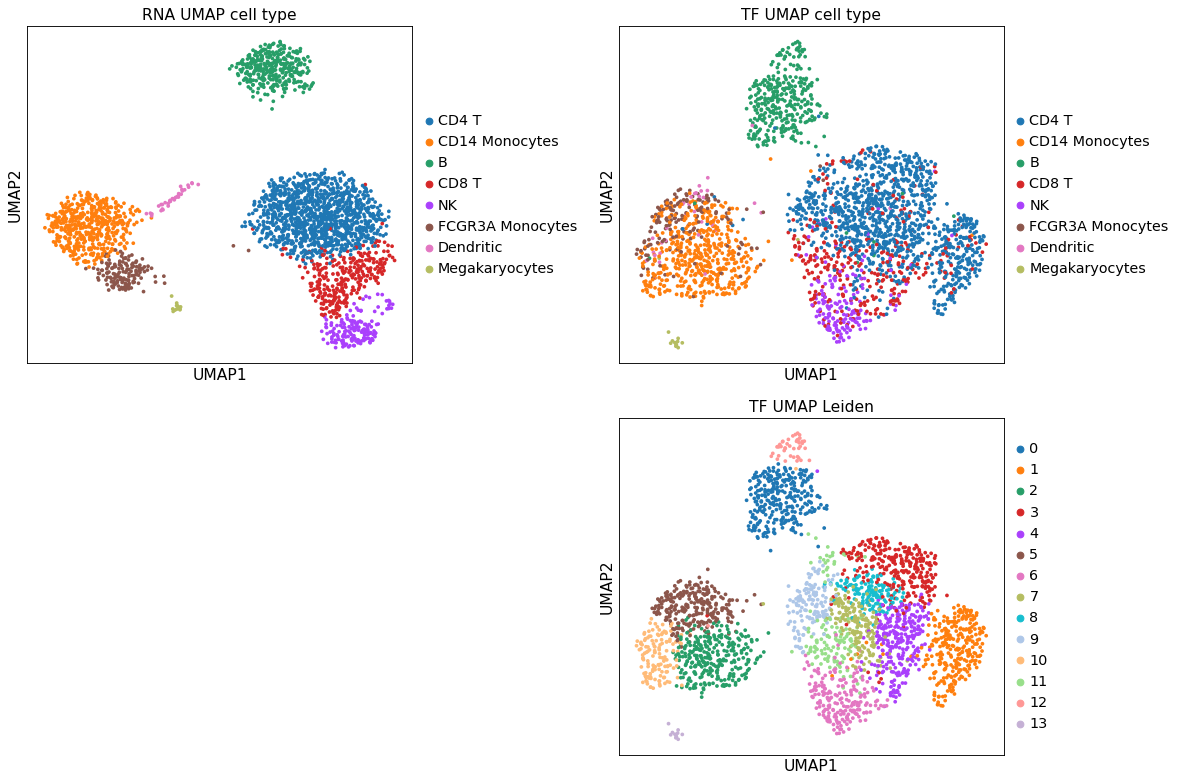

In [18]:
fig, ax = plt.subplots(2,2, figsize=(15,10), tight_layout=True, facecolor='white')
ax = ax.flatten()

sc.pl.umap(adata, color='cell_type', 
           return_fig=False, 
           ax=ax[0], 
           show=False, 
           frameon=True, 
           title='RNA UMAP cell type'
          )

sc.pl.umap(proj_adata, color='cell_type', 
           return_fig=False, 
           ax=ax[1], 
           show=False, 
           frameon=True,
           title='TF UMAP cell type'
          )

ax[2].axis('off')

sc.pl.umap(proj_adata, 
           color='leiden', 
           return_fig=False, 
           ax=ax[3], 
           show=False, 
           frameon=True, 
           title='TF UMAP Leiden'
          )
plt.show()

The obtained projection based on TF activities is able to recover the major cell lineages. After applying unsupervised clustering, there seem to be different subclusters inside the T cell cluster which might be interesting to further explore.

## Session info

In [19]:
sc.logging.print_versions(file=None)

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
backcall            0.2.0
cairo               1.20.0
cffi                1.14.5
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
dorothea            NA
get_version         2.1
h5py                3.1.0
igraph              0.8.3
ipykernel           5.3.4
ipython_genutils    0.2.0
jedi                0.18.0
joblib              1.0.1
kiwisolver          1.3.1
legacy_api_wrap     0.0.0
leidenalg           0.8.3
llvmlite            0.36.0
matplotlib          3.3.4
mpl_toolkits        NA
natsort             7.1.1
numba               0.53.0
numexpr             2.7.3
numpy               1.20.1
packaging           20.9
pandas              1.2.3
parso               0.8.0
patsy               0.5.1
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
prompt_toolkit      3.0.8
ptypro

# References

- Dugourd, Aurelien, and Julio Saez-Rodriguez. 2019. “Footprint-Based Functional Analysis of Multiomic Data.” Current Opinion in Systems Biology 15 (June): 82–90. https://doi.org/10.1016/j.coisb.2019.04.002.


- Garcia-Alonso, Luz, Christian H. Holland, Mahmoud M. Ibrahim, Denes Turei, and Julio Saez-Rodriguez. 2019. “Benchmark and Integration of Resources for the Estimation of Human Transcription Factor Activities.” Genome Research 29 (8): 1363–75. https://doi.org/10.1101/gr.240663.118.


- Holland, Christian H., Jovan Tanevski, Javier Perales-Patón, Jan Gleixner, Manu P. Kumar, Elisabetta Mereu, Brian A. Joughin, et al. 2020. “Robustness and Applicability of Transcription Factor and Pathway Analysis Tools on Single-Cell RNA-Seq Data.” Genome Biology 21 (1). https://doi.org/10.1186/s13059-020-1949-z. 

- Wolf, Alexander, Angerer, Philipp and Theis, Fabian. 2018."SCANPY: large-scale single-cell gene expression data analysis". Genome Biology 19 (15). https://doi.org/10.1186/s13059-017-1382-0